**Creation Date:**

**October 1, 2020**

**created by Engin Deniz ALPMAN**

In [1]:
import torch
import torch.nn as nn
from PIL import Image
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import torch.nn.functional as F
from torchvision.transforms import ToTensor, ToPILImage
import PIL
import pandas as pd

import os
import math

In [2]:
path = Path("data/pascal_2007")

# Multi-Label Classification

* We have to find a way to represent labels as numbers

* In multi-label classification, we expect to see 1 or more objects in the image

## Data

* The file name of the images and their corresponding labels are stored in the csv

In [3]:
df = pd.read_csv(path/"train.csv")

In [4]:
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


### Creating train and validation set

In [5]:
filt = df["is_valid"] == False

In [6]:
df = df.drop(columns = "is_valid")

In [7]:
df_train, df_valid = df[filt], df[~filt]

In [8]:
df_train.head()

,fname,labels
3,000012.jpg,car
5,000017.jpg,person horse
9,000023.jpg,bicycle person
11,000026.jpg,car
13,000032.jpg,aeroplane person


## Resizing

* Images are in different sizes, when we are feeding them to the model, we should resize them to the same size

In [9]:
img = Image.open('data/pascal_2007/train/000005.jpg')
img.size

(500, 375)

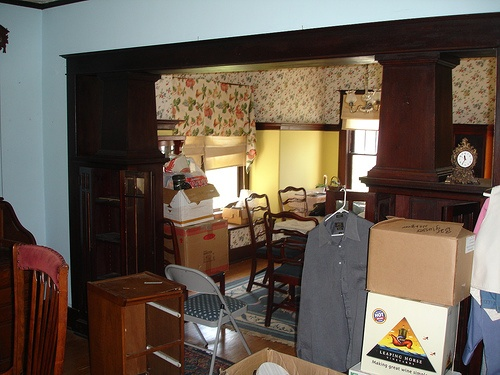

In [10]:
img

In [11]:
img2 = Image.open('data/pascal_2007/train/000026.jpg')
img2.size

(500, 333)

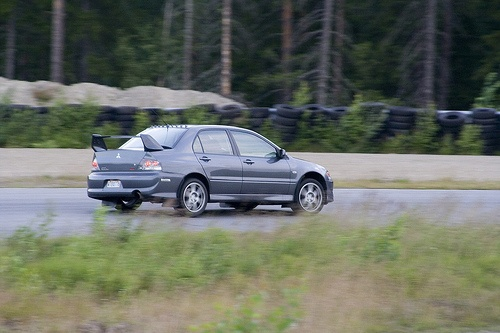

In [12]:
img2

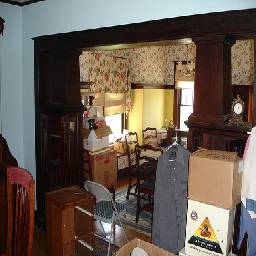

In [13]:
img.resize((256,256))

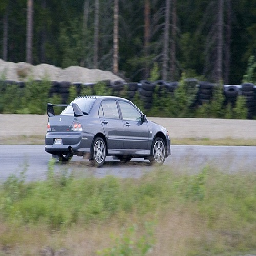

In [14]:
img2.resize((256,256))

## Image labels as one hot encoded vectors

* labels are on the csv but they can be more than one. So "horse person" is not just one class, it has two classes "horse" and "person". So wee need to iterate through that series and create one hot vectors for each of the items

In [15]:
df["labels"]

0                chair
1                  car
2         horse person
3                  car
4              bicycle
             ...      
5006      horse person
5007              boat
5008    person bicycle
5009               car
5010               dog
Name: labels, Length: 5011, dtype: object

In [16]:
for e in df["labels"]:
    print(e)
    break

chair


In [17]:
df["labels"].iloc[2]

'horse person'

In [18]:
# splitting
df["labels"].iloc[2].split(" ")

['horse', 'person']

In [19]:
d = {}
for e in df["labels"]:
        l = e.split(" ")
        for k in l:
            if k not in d:
                d[k] = len(d)

In [20]:
d

{'chair': 0,
 'car': 1,
 'horse': 2,
 'person': 3,
 'bicycle': 4,
 'cat': 5,
 'dog': 6,
 'train': 7,
 'aeroplane': 8,
 'diningtable': 9,
 'tvmonitor': 10,
 'bird': 11,
 'bottle': 12,
 'motorbike': 13,
 'pottedplant': 14,
 'boat': 15,
 'sofa': 16,
 'sheep': 17,
 'cow': 18,
 'bus': 19}

* So, now we can represent categories as numbers

In [21]:
inverse_d = {v: k for k, v in d.items()}

In [22]:
inverse_d

{0: 'chair',
 1: 'car',
 2: 'horse',
 3: 'person',
 4: 'bicycle',
 5: 'cat',
 6: 'dog',
 7: 'train',
 8: 'aeroplane',
 9: 'diningtable',
 10: 'tvmonitor',
 11: 'bird',
 12: 'bottle',
 13: 'motorbike',
 14: 'pottedplant',
 15: 'boat',
 16: 'sofa',
 17: 'sheep',
 18: 'cow',
 19: 'bus'}

### Function that creates one hot encoded vector for given index

In [23]:
def create_code(df, idx):
    l = [0] * len(d)
    
    labels = df.iloc[idx]["labels"].split(" ")
    labels_code = []
    
    for e in labels:
        l[d[e]] = 1
    
    return torch.tensor(l, dtype = torch.long)

In [24]:
create_code(df, 2)

tensor([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Looking which labels are in this vector

In [25]:
msk = create_code(df, 2).type(torch.bool)

In [26]:
(np.array(list(d.keys())))[msk]

array(['horse', 'person'], dtype='<U11')

### Writing Transform function for images

* Function that resize images and transform them to the float32 pytorch tensor for our model

In [27]:
def transform_image(pth):
    img = Image.open(pth)
    return (ToTensor()(img.resize((256,256)))).type(torch.float32)

## Creating Dataset

* Our dataloader logic will be same as before, it will send request to oru dataset class to get batch of items.

* But the problem is that size of our dataset might be bigger than our RAM. So we need to design our dataset so that it will load images form our disk instead of RAM. 

In [28]:
class Dataset():
    def __init__(self, df, pth): 
        self.x ,self.y = df["fname"], df["labels"]
        self.path = path/pth
        
    def __len__(self): 
        return len(self.x)
    def __getitem__(self, idxs):
        if isinstance(idxs, int):
            imgs = transform_image(path/self.pth/self.df.iloc[idxs])
            labels = create_code(self.df, idxs)
        else:
            sub_df = self.df[idxs]
            imgs = transform_image(path/self.pth/sub_df.iloc[0])
            labels = create_code(sub_df, 0)
            for i in range(1, len(idxs)):
                e = sub_df.iloc[i]
                imgs = torch.cat((imgs,transform_image(path/self.pth/e)))
                labels = torch.cat((labels, create_code(sub_df, i)))
            
        return imgs.cuda(), labels.cuda()

            
            

In [29]:
class Dataset():
    def __init__(self, df, path): 
        self.df = df
        self.path = path
        
    def __len__(self): 
        return len(self.df)
    def __getitem__(self, idxs):
        if isinstance(idxs, int):
            imgs = transform_image(self.path/self.df.iloc[idxs]["fname"])
            labels = create_code(self.df, idxs)
        else:
            sub_df = self.df.iloc[idxs]
            imgs = transform_image(self.path/sub_df.iloc[0]["fname"])
            labels = create_code(sub_df, 0)
            for i in range(1, len(idxs)):
                e = sub_df.iloc[i]["fname"]
                imgs = torch.cat((imgs,transform_image(self.path/e)))
                labels = torch.cat((labels, create_code(sub_df, i)))
            
        return imgs, labels

In [30]:
class DataLoader():
    def __init__(self, ds, bs): 
        self.ds, self.bs = ds, bs
    def __iter__(self):
        n = len(self.ds)
        l = torch.randperm(n)

        
        for i in range(0, n, self.bs): 
            idxs_l = l[i:i+self.bs]
            yield self.ds[idxs_l]

In [31]:
train_ds = Dataset(df_train, path/"train")
train_dl = DataLoader(train_ds, 64)

In [32]:
%time x, y = next(iter(train_dl))

Wall time: 653 ms


In [33]:
%%time 
for x, y in train_dl:
    pass

Wall time: 24.9 s


* It takes long time to load 1 epoch. So we will look what takes time and try to decrease it with changing them

In [34]:
%%prun
for x, y in train_dl:
    pass

* It seems like torch.cat is taking long time, so we will try not to use it

In [35]:
class Dataset():
    def __init__(self, df, path): 
        self.df = df
        self.path = path
        
    def __len__(self): 
        return len(self.df)
    def __getitem__(self, idxs):
        if isinstance(idxs, int):
            imgs = [transform_image(self.path/self.df.iloc[idxs]["fname"])]
            labels = [create_code(self.df, idxs)]
        else:
            sub_df = self.df.iloc[idxs]
            imgs = []
            labels = []
            for i in range(len(idxs)):
                e = sub_df.iloc[i]["fname"]
                imgs.append(transform_image(self.path/e))
                labels.append(create_code(sub_df, i))
            
        return torch.stack(imgs).cuda(), torch.stack(labels).cuda()
            

In [36]:
class DataLoader():
    def __init__(self, ds, bs): 
        self.ds, self.bs = ds, bs
    def __iter__(self):
        n = len(self.ds)
        l = torch.randperm(n)

        
        for i in range(0, n, self.bs): 
            idxs_l = l[i:i+self.bs]
            yield self.ds[idxs_l]

In [37]:
train_ds = Dataset(df_train, path/"train")
train_dl = DataLoader(train_ds, 64)

In [38]:
%%time 
for x, y in train_dl:
    pass

Wall time: 6.87 s


## Normalization Problem

* Before we had all our data in RAM so we could do somethings like data.mean(), data.std(). 

* But now we don't it stored in **one variable**.

* So we need to find a way to calculate mean and std while we are looking at batches

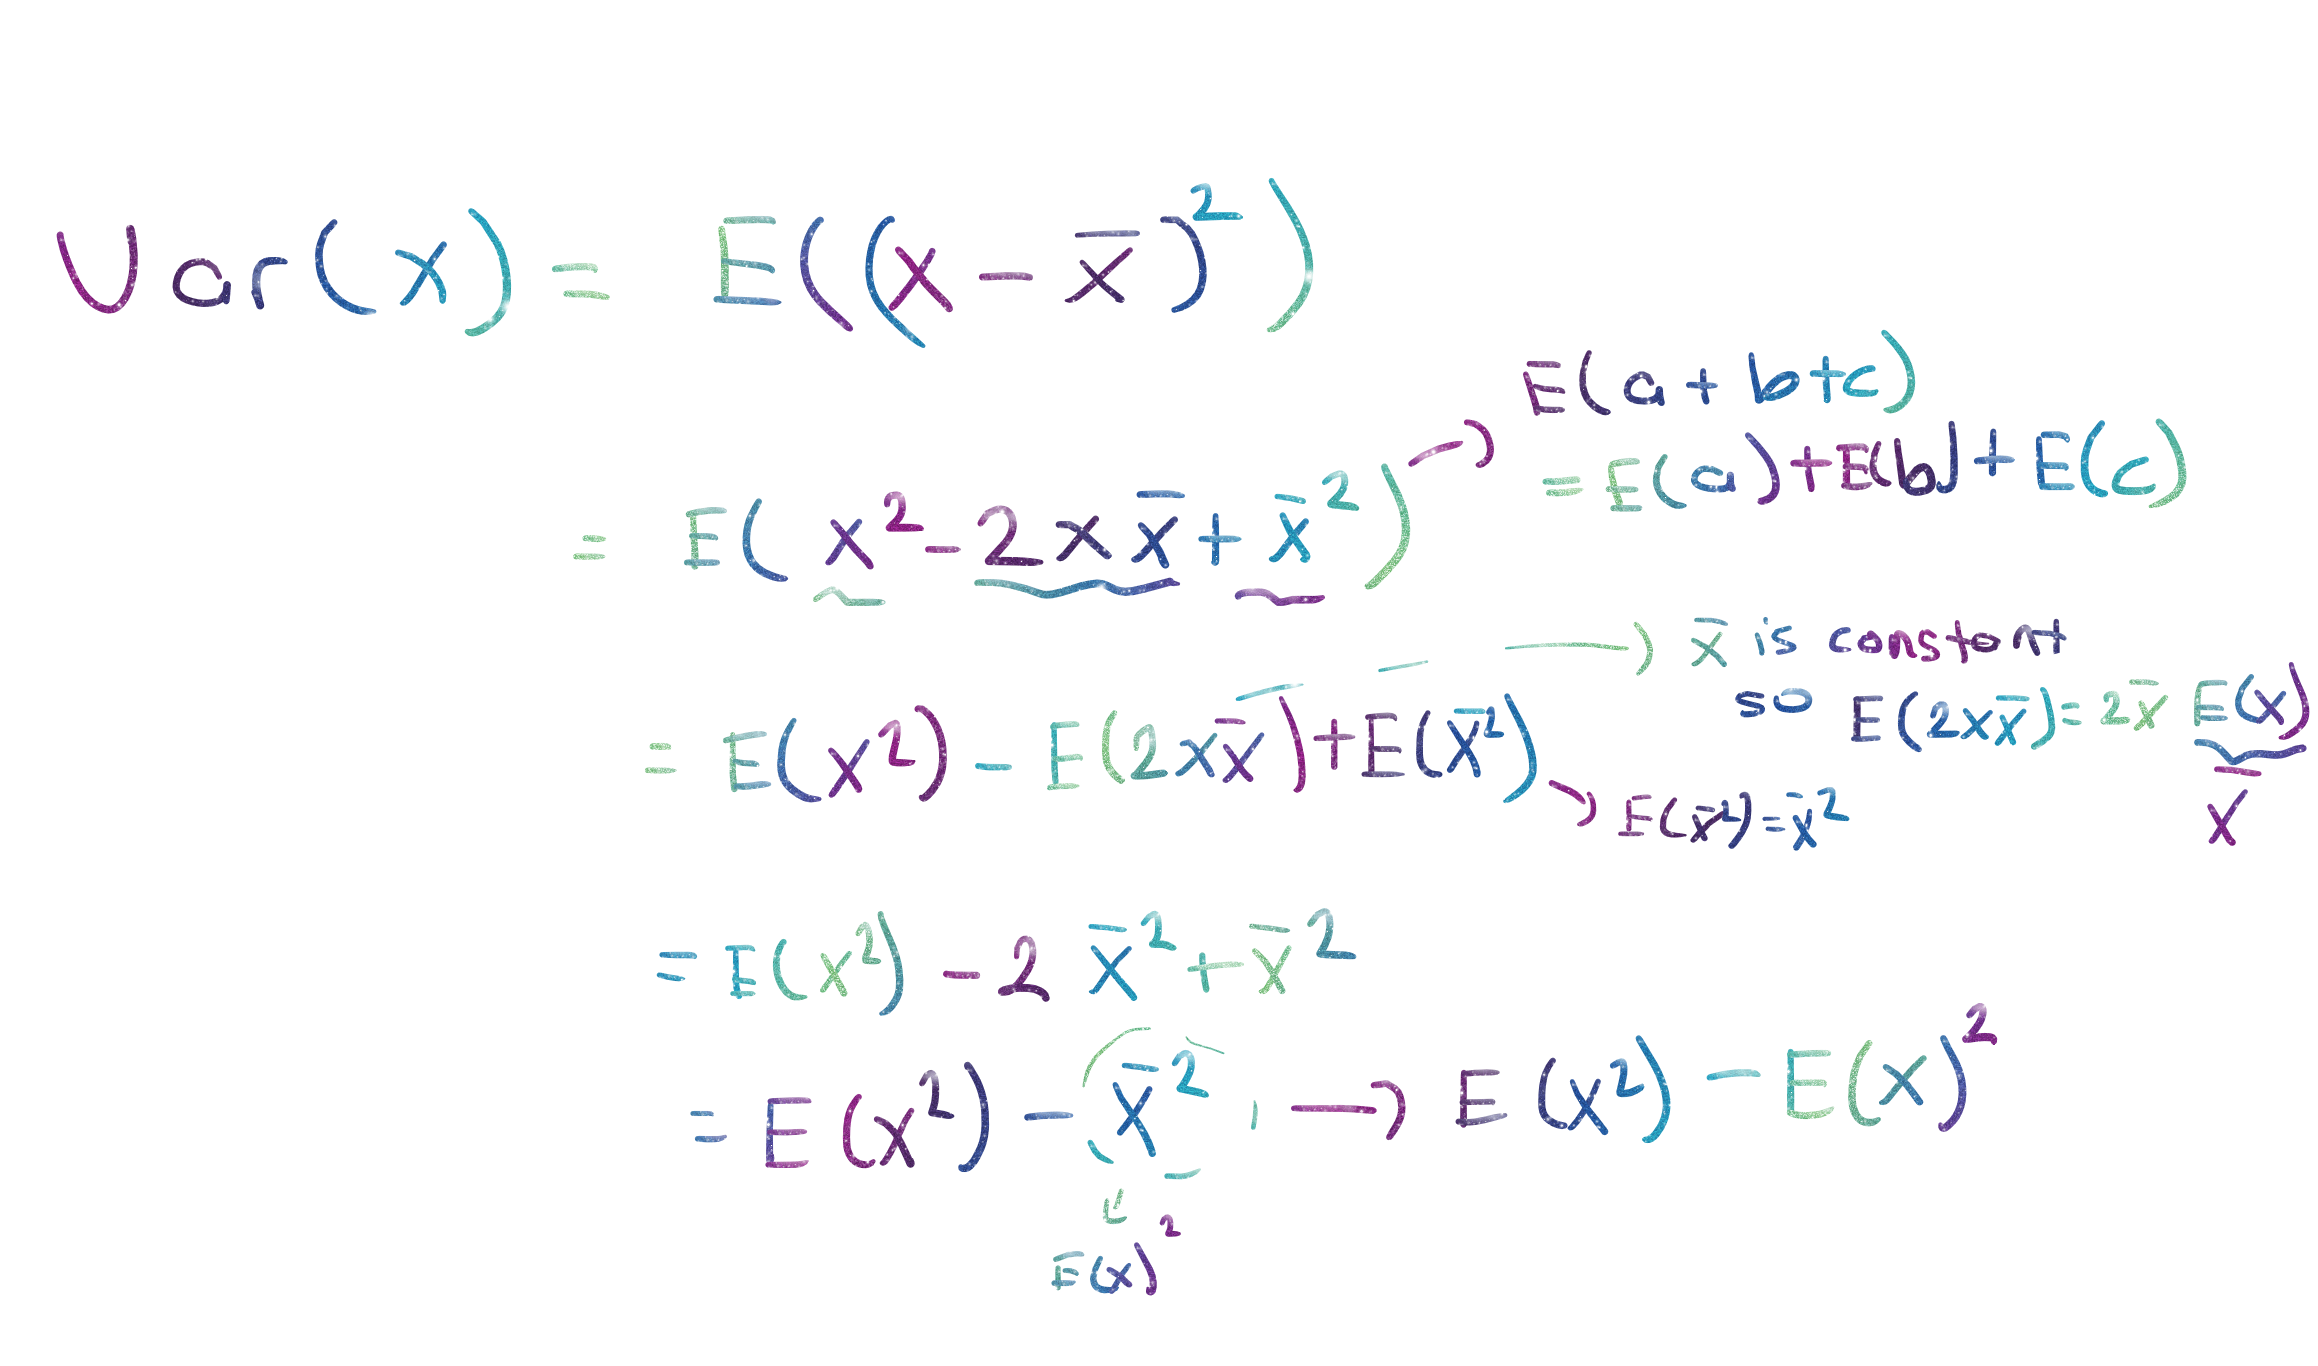

In [39]:
n = len(df_train)

In [40]:
x, y = next(iter(train_dl))

In [41]:
sum_x = 0
sum_x_2 = 0
for xb, _ in train_dl:
    temp = xb.sum((0,2,3), keepdim = True) # per channel
    sum_x += temp
    sum_x_2 += (xb ** 2).sum((0,2,3), keepdim = True)

In [42]:
mean_x = (sum_x / (n * x.shape[2] * x.shape[3])).cpu()

In [43]:
mean_x_2 = (sum_x_2 / (n * x.shape[2] * x.shape[3])).cpu()

In [44]:
std = torch.sqrt(mean_x_2 - mean_x ** 2)

In [45]:
std

tensor([[[[0.2750]],

         [[0.2720]],

         [[0.2845]]]])

In [46]:
mean_x.squeeze_(0)

tensor([[[0.4472]],

        [[0.4231]],

        [[0.3912]]])

In [47]:
std.squeeze_(0)

tensor([[[0.2750]],

        [[0.2720]],

        [[0.2845]]])

### Testing if our normalizatio worked

In [48]:
((x.cpu() - mean_x) / std).mean()

tensor(-0.0161)

In [49]:
((x.cpu() - mean_x) / std).std()

tensor(1.0072)

## Writing new transformation method that also does normalization

In [50]:
def transform_image(pth):
    img = Image.open(pth)
    return (((ToTensor()(img.resize((256,256)))).type(torch.float32)) - mean_x) / std

In [51]:
img3 = transform_image('data/pascal_2007/train/000026.jpg')

In [52]:
img3

tensor([[[-1.1984, -1.1841, -1.1556,  ..., -1.2412, -1.2554, -1.2554],
         [-1.1414, -1.2269, -1.2269,  ..., -1.3125, -1.2554, -1.2840],
         [-1.1414, -1.1128, -1.1699,  ..., -1.2697, -1.2697, -1.3553],
         ...,
         [ 0.4130,  0.5271,  0.4843,  ...,  0.1991,  0.2419,  0.2561],
         [ 0.3274,  0.2847,  0.2847,  ...,  0.1135,  0.1278,  0.0708],
         [ 0.2989,  0.2561,  0.2419,  ...,  0.4700,  0.4415,  0.3417]],

        [[-0.9212, -0.9212, -0.8635,  ..., -0.9933, -1.0077, -1.0221],
         [-0.8635, -0.9644, -0.9356,  ..., -1.0653, -1.0221, -1.0509],
         [-0.8779, -0.8491, -0.8779,  ..., -1.0365, -1.0365, -1.1230],
         ...,
         [ 0.5062,  0.5927,  0.5494,  ...,  0.3620,  0.4053,  0.4197],
         [ 0.4197,  0.3764,  0.3476,  ...,  0.2322,  0.2611,  0.2034],
         [ 0.3908,  0.3476,  0.3043,  ...,  0.5494,  0.5350,  0.4341]],

        [[-1.0855, -1.0442, -0.9753,  ..., -0.9753, -0.9891, -0.9753],
         [-1.0304, -1.0855, -1.0442,  ..., -1

In [53]:
img3.mean()

tensor(-0.0475)

In [54]:
img3.std()

tensor(0.7812)

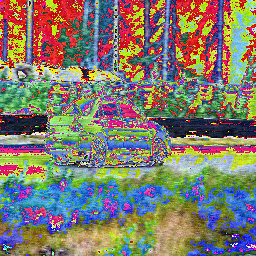

In [55]:
ToPILImage()(img3)

* Wow that is a mess

* hmm why did that happened??

* Because we normalized it, so we should apply reverse transformation to view it as usual

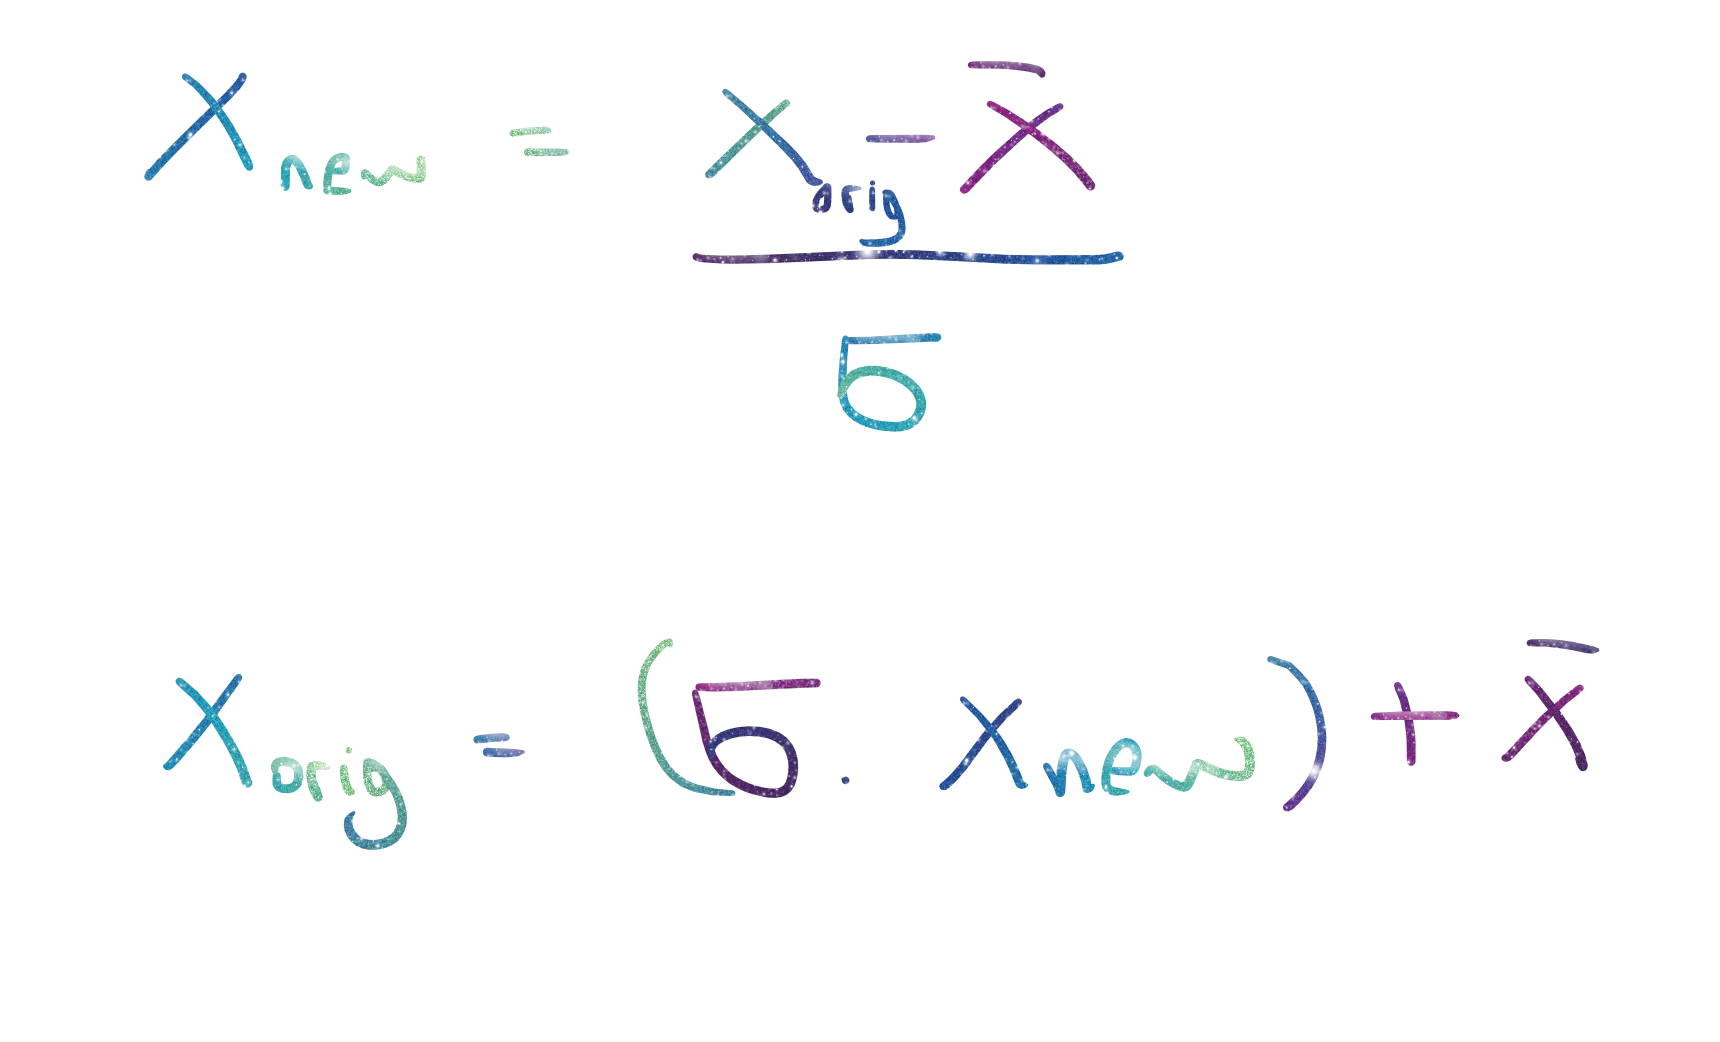

* Don't forget, images are just numbers that are stored in computer, so we can add, multiply, we can do all kind of arithmetic operations to them.

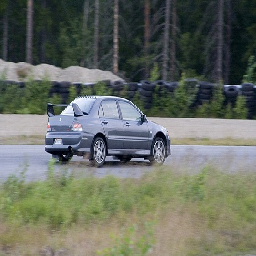

In [56]:
ToPILImage()(img3 * std + mean_x)

## Loss Function

* Can we use both of them as a loss function, are there any differences, if any what are those?

In [57]:
def binary_cross_entropy_logits(preds, targets):
    preds = preds.sigmoid()
    return torch.where(targets==1, 1-preds, preds).log().mean()

In [58]:
def binary_cross_entropy_logits(preds, targets):
    preds = preds.sigmoid()
    return -torch.where(targets==1, preds, 1-preds).log().mean()

In [59]:
loss_func = binary_cross_entropy_logits

* Our model will say which categories are present in our images, so we will use the same number of sigmoid as our number of categories in output layer for them to tell us whether or not those classes are present or not

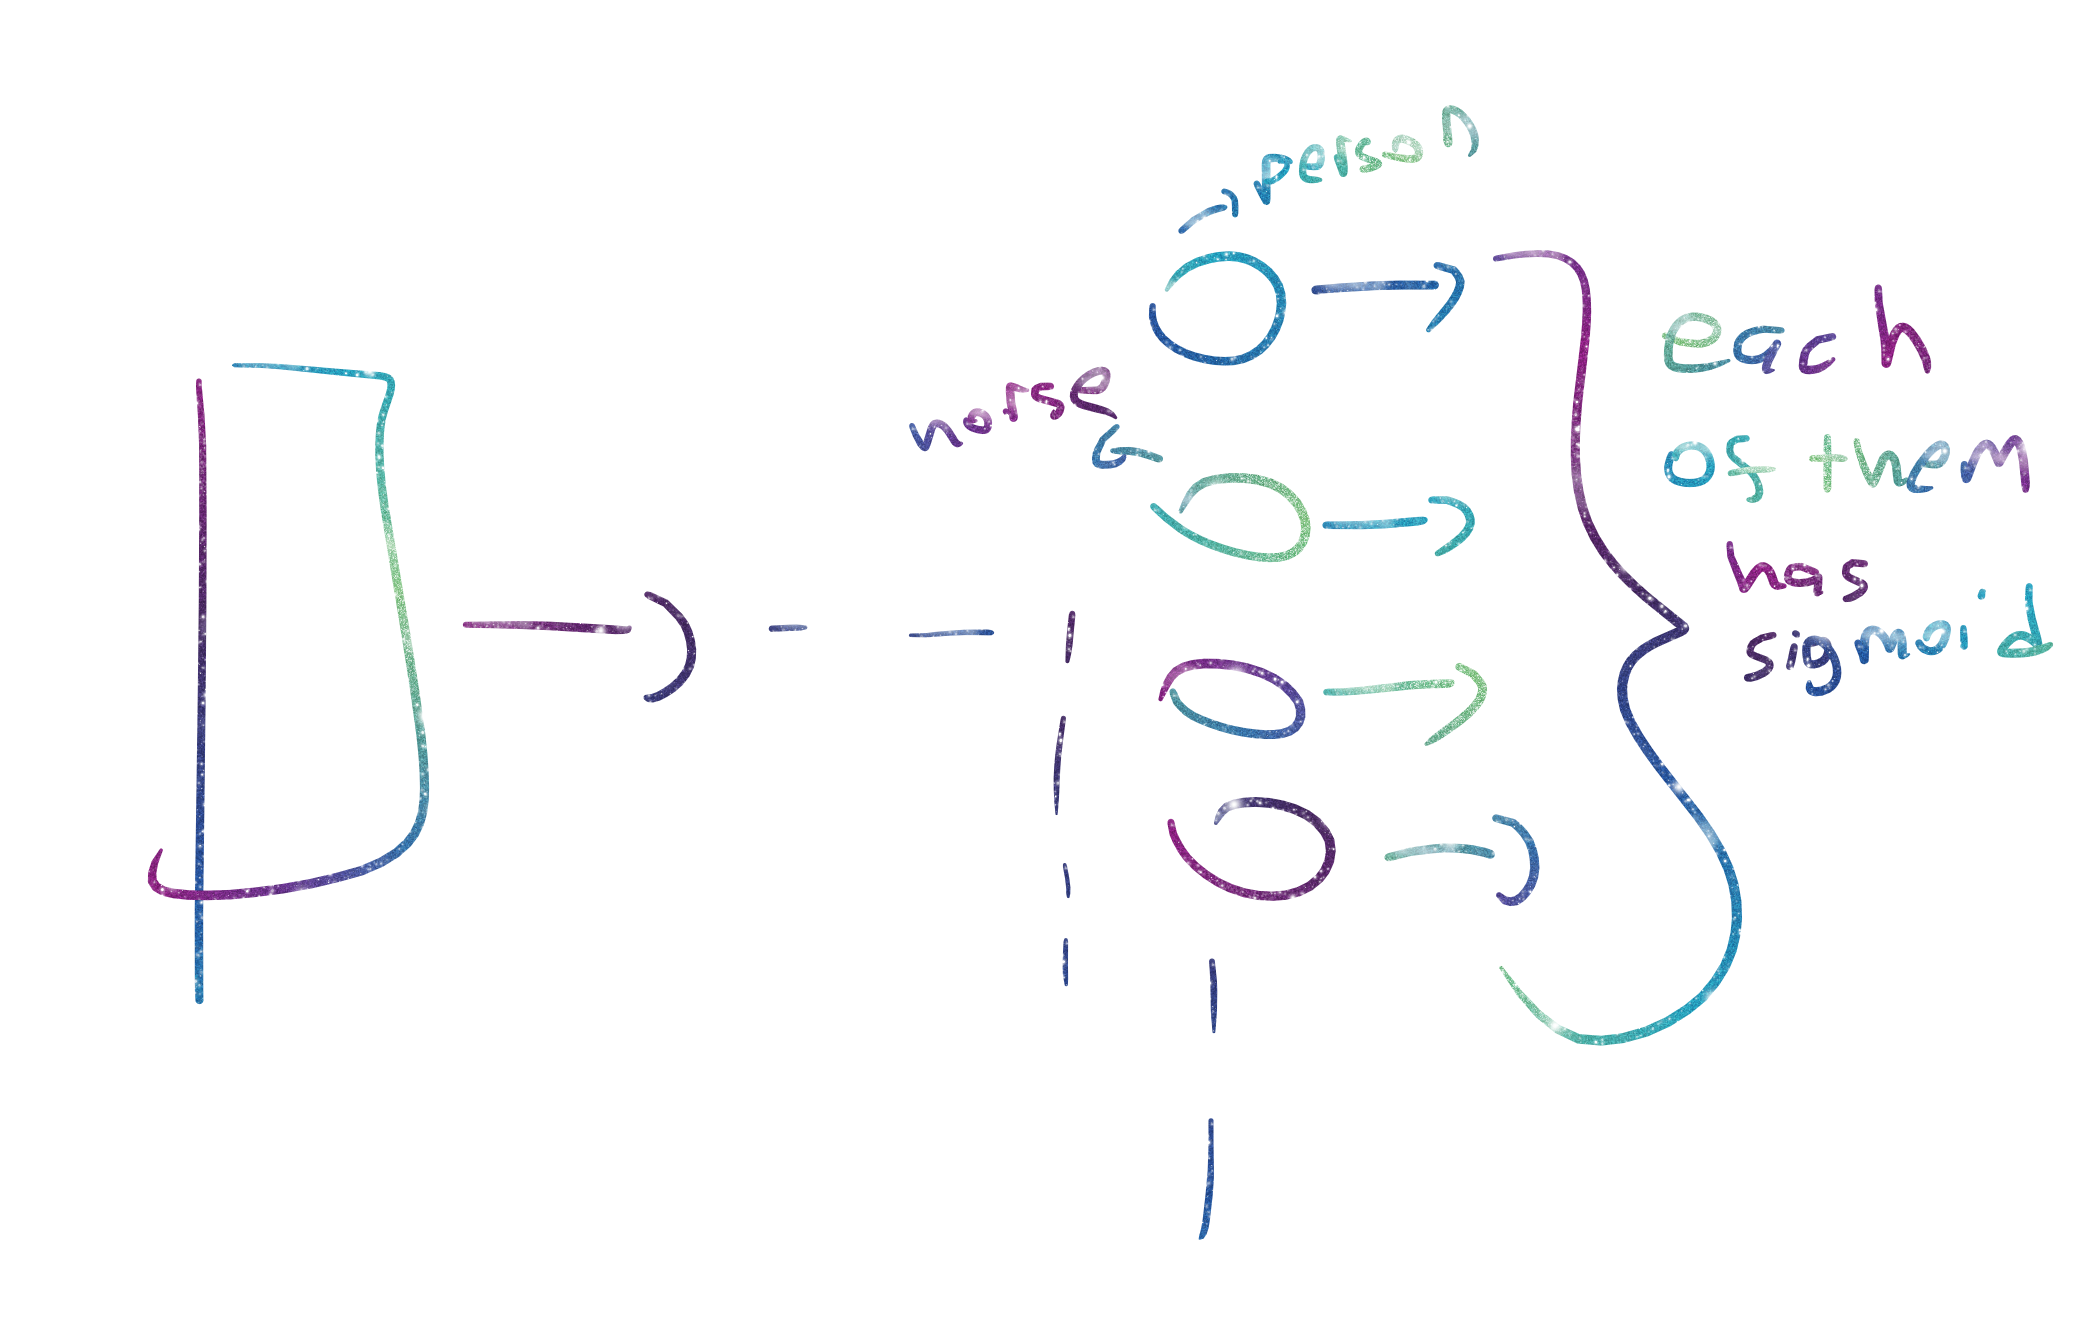

In [60]:
def validation_acc(model):
    return torch.stack([accuracy_multi(model(xb), yb) for xb, yb in valid_dl]).mean().item()

In [61]:
def accuracy_multi(preds, yb, threshold = 0.5):
    preds = preds.sigmoid()
    return ((preds > threshold) == yb).float().mean()

In [62]:
def train(model, epochs=5, valid_epoch=5):
    for epoch in range(1, epochs+1):
        model = model.train()
        for xb, yb in train_dl:
            
            preds = model(xb)
            loss = loss_func(preds, yb.type(torch.float32))
            loss.backward()
            optim.step()
            optim.zero_grad()
        
        if epoch  % valid_epoch == 0:
            model = model.eval()
            with torch.no_grad():
                print(validation_acc(model))

## Creating Our model

In [63]:
train_ds = Dataset(df_train, path/"train")
train_dl = DataLoader(train_ds, 64)

In [64]:
valid_ds = Dataset(df_valid, path/"train")
valid_dl = DataLoader(valid_ds, 64)

In [65]:
class Func(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): 
        return self.func(x)

In [66]:
def flatten(x):      
    return x.view(x.shape[0], -1)

In [71]:
model = nn.Sequential(
        nn.Conv2d(3, 8, 5, padding=2,stride=2), nn.ReLU(), nn.BatchNorm2d(8), #14
        nn.Conv2d(8, 16, 3, padding=1,stride=2), nn.ReLU(),nn.BatchNorm2d(16), # 7
        nn.Conv2d(16, 32, 3, padding=1,stride=2), nn.ReLU(),nn.BatchNorm2d(32), # 4
        nn.Conv2d(32, 64, 3, padding=1,stride=2), nn.ReLU(),nn.BatchNorm2d(64), # 2
        nn.Conv2d(64, 128, 3, padding=1,stride=2), nn.ReLU(),nn.BatchNorm2d(128),
        nn.Conv2d(128, 256, 3, padding=1,stride=2), nn.ReLU(),nn.BatchNorm2d(256),
        nn.AdaptiveAvgPool2d(1),
        Func(flatten),
        nn.Linear(256,128), nn.ReLU(),
        nn.Linear(128, 20)
).cuda()

In [72]:
optim = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-3)

In [73]:
train(model,10,2)

0.6149023771286011
0.7648242712020874
0.8577119708061218
0.897879421710968
0.9136300086975098
